In [66]:
! pip install --upgrade torch # 
! pip install --upgrade tqdm  # necesary for pytorch 4.4

Requirement already up-to-date: torch in /opt/conda/lib/python3.6/site-packages (1.4.0)
Requirement already up-to-date: tqdm in /opt/conda/lib/python3.6/site-packages (4.42.0)


# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

**Note: if you are using the Udacity workspace, you *DO NOT* need to re-download these - they can be found in the `/data` folder as noted in the cell below.**

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [67]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


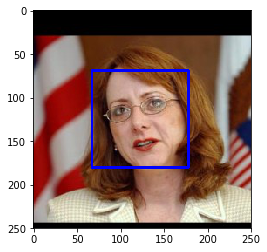

In [68]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[15])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [69]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return 0 != len(faces)

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

Accuracy for human images: 98.0%

Accuracy for dog images: 83.0%

In [70]:
from tqdm import tqdm

In [71]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

# function to obtain accuracy
def naive_score(list_results):
    total_images = len(list_results)
    correct_class = len(list(filter(lambda x: x == True, list_results)))
    accuracy_naive = correct_class/total_images
    return accuracy_naive

# function to loop trough immages and detect faces
def accuracy_model(model, list_paths_imgs):
    global results_classifier
    results_classifier = []
    for img_path in tqdm(list_paths_imgs):
        results_classifier.append(model(img_path))
    accuracy = naive_score(results_classifier)*100
    return accuracy

# show the results
accuracy_humans = accuracy_model(face_detector, human_files_short)
print("Accuracy for human images: {}%".format(accuracy_humans))

accuracy_dogs = 100 - accuracy_model(face_detector, dog_files_short) # a no detection of a humann face is good!
print("Accuracy for dog images: {}%".format(accuracy_dogs))

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy for human images: 98.0%


100%|██████████| 100/100 [00:30<00:00,  3.33it/s]

Accuracy for dog images: 83.0%


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [72]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.
# maybe later =)

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [73]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# use_cuda = False #  torch.cuda.is_available()
use_cuda = torch.cuda.is_available()

# check if CUDA is available
#  use_cuda = torch.cuda.is_available()
# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [74]:
from torchvision import datasets, models, transforms
import os
import glob
import torchvision.transforms as transforms
from PIL import Image
Image.LOAD_TRUNCATED_IMAGES = True
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

Load some images for testing

In [75]:
images = glob.glob("/home/workspace/dog_project/images/*")
images[3]

'/home/workspace/dog_project/images/sample_human_output.png'

In [76]:
def data_transforms_compose(image):
    """apply transformations to image"""
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

    prediction_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                     transforms.ToTensor(), 
                                     normalize])
    return prediction_transform(image)

In [77]:
def image_loader(img_path):
    """load image, returns cuda tensor"""
    image = Image.open(img_path).convert('RGB')

    # apply transforms
    image = data_transforms_compose(image).float()
    #  image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not needed for ResNet

    if use_cuda:
        return image.cuda()  #assumes that you're using GPU
    else:
        return image


In [78]:
def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''

    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
                           
    image = image_loader(img_path)

    predicted_class = VGG16(image)
    
    # index of predicted class
    arg_max = torch.argmax(predicted_class).item()
    
    return arg_max # predicted class index

In [79]:
VGG16_predict(images[5])

206

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [80]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    # obtain the class
    predicted_class = VGG16_predict(img_path)
    
    # check if is a doog breed
    return 151 <= predicted_class <= 268

In [81]:
dog_detector(images[2])

True

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


In [82]:

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

# function to obtain accuracy
def naive_score(list_results):
    total_images = len(list_results)
    correct_class = len(list(filter(lambda x: x == True, list_results)))
    accuracy_naive = correct_class/total_images
    return accuracy_naive

# function to loop trough immages and detect faces
def accuracy_model(model, list_paths_imgs):
    global results_classifier
    results_classifier = []
    for img_path in tqdm(list_paths_imgs):
        results_classifier.append(model(img_path))
    accuracy = naive_score(results_classifier)*100
    return accuracy


# show the results
accuracy_humans = 100 - accuracy_model(dog_detector, human_files_short) # a no detection of a dog is good!
print("Accuracy for human images: {}%".format(accuracy_humans))

accuracy_dogs = accuracy_model(dog_detector, dog_files_short) 
print("Accuracy for dog images: {}%".format(accuracy_dogs))

  3%|▎         | 3/100 [00:00<00:03, 28.49it/s]

Accuracy for human images: 100.0%


100%|██████████| 100/100 [00:04<00:00, 25.68it/s]

Accuracy for dog images: 100.0%


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [83]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [84]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

In [85]:
import os
from torchvision import datasets
import numpy as np

define transformations

In [86]:
size_img = 112


#  normalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def data_transforms_train(image):
    data_transform = transforms.Compose([transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor(),
                                         normalize])
    return data_transform(image)

def data_transforms_valid(image):
    data_transform = transforms.Compose([transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         normalize])
    return data_transform(image)


def data_transforms_test(image):
    data_transform = transforms.Compose([transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                          normalize])
    return data_transform(image)


load the breeds or classes

In [87]:
f = open("./dictionary_classes/imagenet1000_clsidx_to_labels.txt", "r")

breeds = []
for line in f:   ## iterates over the lines of the file
    breed = line.split(": ")[1].split("'")[1]
    breeds.append(breed)
f.close()

breeds[:5]

['tench, Tinca tinca',
 'goldfish, Carassius auratus',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'tiger shark, Galeocerdo cuvieri',
 'hammerhead, hammerhead shark']

In [88]:
# define training, test and validation data directories
data_dir = '/data/dog_images/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')
valid_dir = os.path.join(data_dir, 'valid/')

classes =  [x[0].split("/")[-1] for x in os.walk(train_dir)][1:]
classes.sort()
classes[:4]

['001.Affenpinscher', '002.Afghan_hound', '003.Airedale_terrier', '004.Akita']

In [89]:
# choose the training and test datasets
train_data = datasets.ImageFolder(train_dir,
                                  transform=data_transforms_train)
test_data = datasets.ImageFolder(test_dir,
                                  transform=data_transforms_test)
valid_data = datasets.ImageFolder(valid_dir,
                                  transform=data_transforms_valid)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))
print('Num valid images: ', len(test_data))

Num training images:  6680
Num test images:  836
Num valid images:  836


In [90]:
import torchvision
import torch

In [91]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

#  sampler1 = torch.utils.data.RandomSampler(train_data, replacement=True, num_samples=num_samples)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           shuffle=True,num_workers=num_workers, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=False, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=False, drop_last=True)

save trainloaders in a dict:

In [92]:
loaders_scratch = {}
loaders_scratch["train"] = train_loader
loaders_scratch["test"] = test_loader
loaders_scratch["valid"] = valid_loader

Show some examples

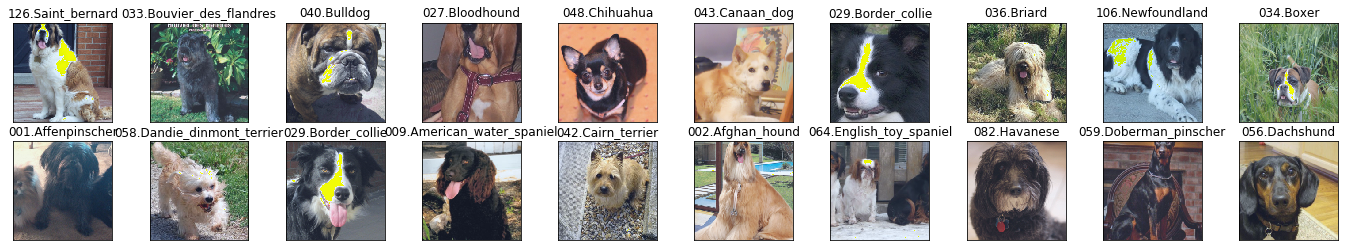

In [93]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 5 + .5   # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(24, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

**Question 3:** Describe your chosen procedure for preprocessing the data. 

1. How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?

2. Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**:

**1. A:**

I used torch.transformation() first I resized the ics ath 256x256 and then I applied a center crop of 224x224 to focus on the center of the image. I choosed 224 because is the minimum size that VGG acepts and because I think that this resolution is enough for the process.

**2. A**

I applied transforms.RandomHorizontalFlip(), and I got 11-14% of correct predictions using different nets. I tried other data augmentation techniques but since the train, test and valid photos correspond to amateur photos of dogs, and no 'ideal training photos' and 'real photos' I did not perceived real improvements.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

---

I struggle a lot with padding and stride...

So implmented the formula that was described in "CNNs for CIFAR Image Classification" to get the output size of net layer and check if the ouput size an integer, if not the code suggests you different filter, padding and stride options simmilar with the original ones.

In [94]:
import itertools
import math

def w_out_calc(w, f, p, s):
    """
    Computes the output size of a given convolutional layer Using (W−F+2P)/S+1
    Source: http://cs231n.github.io/convolutional-networks/#layers
    """
    num = w - f + 2 * p
    denom = s

    output_w = (num / denom) + 1
    return output_w


def is_integer(number):
    """ Checks if number is integer """
    return number == int(number)

def output_volume_net(w_input, filter_size,stride, padding,
                      filter_grid=(1,4), stride_grid=(1,4), padding_grid=(0,4),
                    maxpool=1):
    """
    Search for possible parameters if w_out is not int:

    Parameters
    ----------
    w_input: Padding int
        Input volume size
        
    filter_size: int
        kernel/filter size
        
    padding: int
        Amount of zero padding
    
    stride: int
        Stride of the filter
        
    stride_grid: tuple
        (min, max) search area for stride

    filter_grid: tuple
        (min, max) search area for filter
    
    padding_grid: tuple
        (min, max) search area for padding
            
     Returns
    -------
    int
         output_w, size of the output.
        
    """
    params_names = ["filter_size","padding","stride"]
    
    # print initial params
    print("With the parameters: \n")
    print("  w_input", "  filter_size","   padding","   stride")
    print("".join(["_" for _ in range(60)]))
    print("    {}            {}            {}         {}   \n".format(
                        w_input, filter_size, padding, stride))

    output_w = w_out_calc(w=w_input ,f=filter_size, p=padding, s=stride)
    output_w = math.floor(output_w /maxpool)

    # check if result is an integer
    if is_integer(output_w):
        print(" W_out = {} is an integer!".format(output_w))

    else:
        print("W_out = {} is not an integer...\n ".format(output_w))
        print("You can try with the following parameters: \n")
    
        # iterates over different parameters to obtain a fitted output
        param_grid = {}
        param_grid["filter_size"] = [i for i in range(filter_grid[0], filter_grid[1] + 1)]
        param_grid["padding"] = [i for i in range(padding_grid[0], padding_grid[1]+1)]
        param_grid["stride"] = [i for i in range(stride_grid[0], stride_grid[1]+1)]

        print("  w_input", "  filter_size","   padding","   stride", "   w_out")
        print("".join(["_" for _ in range(60)]))

        # generate all the params combinations
        param_combinations = list(
            itertools.product(param_grid["filter_size"],param_grid["padding"],param_grid["stride"]))
        
        # iterate over solutions to find the desired params
        for filter_it, padding_it, stride_it in param_combinations:
            w_out_try = w_out_calc(w=w_input ,f=filter_it, p=padding_it, s=stride_it)
            w_out_try = math.floor(w_out_try / maxpool)

            if is_integer(w_out_try):

                print("    {}            {}            {}         {}    |  {}  ".format(
                    w_input, filter_it, padding_it, stride_it, int(w_out_try)))

function example

In [155]:
output_volume_net(w_input=55, filter_size=3, stride=2, padding=1,
                  filter_grid=(3, 3), stride_grid=(2,3), padding_grid=(0,4),
                 maxpool=2)

With the parameters: 

  w_input   filter_size    padding    stride
____________________________________________________________
    55            3            1         2   

 W_out = 14 is an integer!


In [142]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

        # pool
        self.pool = nn.MaxPool2d(2, 2)
        
        # fully-connected
        self.fc1 = nn.Linear(7*7*128, 500)
        self.fc2 = nn.Linear(500, 133) 
        
        # drop-out
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        ## Define forward behavior
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        # flatten
        x = x.view(-1, 7*7*128)
        
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        
        x = self.dropout(x)
        x = self.fc2(x)
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()
print(model_scratch)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6272, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=133, bias=True)
  (dropout): Dropout(p=0.3)
)


__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

I started with the CIFAR solution that you gave us and nodified the stride and number of width layers. This was a fail and error process.

![alt text](./my_assets/architecture1.png "Title")



### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [143]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr = 0.05)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [144]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path, last_validation_loss=None):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    if last_validation_loss is not None:
        valid_loss_min = last_validation_loss
    else:
        valid_loss_min = np.Inf
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))

            # initialize weights to zero
            optimizer.zero_grad()
            
            output = model(data)
            
            # calculate loss
            loss = criterion(output, target)
            
            # back prop
            loss.backward()
            
            # grad
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [145]:
# train the model
model_scratch = train(20, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 4.858083 	Validation Loss: 4.742667
Validation loss decreased (inf --> 4.742667).  Saving model ...
Epoch: 2 	Training Loss: 4.577096 	Validation Loss: 4.506982
Validation loss decreased (4.742667 --> 4.506982).  Saving model ...
Epoch: 3 	Training Loss: 4.372447 	Validation Loss: 4.443144
Validation loss decreased (4.506982 --> 4.443144).  Saving model ...
Epoch: 4 	Training Loss: 4.236633 	Validation Loss: 4.232749
Validation loss decreased (4.443144 --> 4.232749).  Saving model ...
Epoch: 5 	Training Loss: 4.109765 	Validation Loss: 4.147278
Validation loss decreased (4.232749 --> 4.147278).  Saving model ...
Epoch: 6 	Training Loss: 3.990350 	Validation Loss: 4.184865
Epoch: 7 	Training Loss: 3.856266 	Validation Loss: 3.996162
Validation loss decreased (4.147278 --> 3.996162).  Saving model ...
Epoch: 8 	Training Loss: 3.708109 	Validation Loss: 3.984260
Validation loss decreased (3.996162 --> 3.984260).  Saving model ...
Epoch: 9 	Training Loss: 3.517872 

KeyboardInterrupt: 

> The Validation Loss wasn't improving so I stopped the training

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [148]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        pred = pred.view(1,batch_size)
        correct += np.sum(pred.eq(target.data.view_as(pred)).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [149]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 5.004627


Test Accuracy: 11% (95/820)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

## TODO: Specify data loaders
I will use the same data loaders...

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [112]:
import torchvision.models as models
import torch.nn as nn

In [101]:
## TODO: Specify model architecture 
model_transfer =  models.resnet50(pretrained=True)
    
print(model_transfer)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [102]:
# Freeze training for all "features" layers
for param in model_transfer.parameters():
    param.requires_grad = False

In [103]:
model_transfer.fc = nn.Linear(2048, 133, bias=True)
fc_parameters = model_transfer.fc.parameters()


In [104]:
print(model_transfer.fc.in_features) 
print(model_transfer.fc.out_features) 

2048
133


In [105]:
for param in fc_parameters:
    param.requires_grad = True

In [106]:
model_transfer

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

I just wanted to try the resnet... oh an I saw in the [torch docs](https://pytorch.org/docs/stable/torchvision/models.html) that the resnet 50 was a real good model for image classification.

I only added one final layer because originally the net has 1000 outputs so I tought that one layer from 1000 to 133 outputs would by enough to classify the breeds.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [107]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.fc.parameters(), lr=0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [108]:
# if GPU is available, move the model to GPU
if use_cuda:
    model_transfer = model_transfer.cuda()

In [41]:
# train the model
model_transfer =   train(25, loaders_scratch, model_transfer, optimizer_transfer, 
                      criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 4.803417 	Validation Loss: 4.599979
Validation loss decreased (inf --> 4.599979).  Saving model ...
Epoch: 2 	Training Loss: 4.507698 	Validation Loss: 4.298548
Validation loss decreased (4.599979 --> 4.298548).  Saving model ...
Epoch: 3 	Training Loss: 4.241477 	Validation Loss: 4.019692
Validation loss decreased (4.298548 --> 4.019692).  Saving model ...
Epoch: 4 	Training Loss: 3.995568 	Validation Loss: 3.755827
Validation loss decreased (4.019692 --> 3.755827).  Saving model ...
Epoch: 5 	Training Loss: 3.762728 	Validation Loss: 3.488092
Validation loss decreased (3.755827 --> 3.488092).  Saving model ...
Epoch: 6 	Training Loss: 3.548151 	Validation Loss: 3.305816
Validation loss decreased (3.488092 --> 3.305816).  Saving model ...
Epoch: 7 	Training Loss: 3.336430 	Validation Loss: 3.037784
Validation loss decreased (3.305816 --> 3.037784).  Saving model ...
Epoch: 8 	Training Loss: 3.148133 	Validation Loss: 2.839469
Validation loss decreased (3.03778

I wasnt able to load my model because I had all the imes in lista_state, I had to remove them from the dic...
https://discuss.pytorch.org/t/unexpected-key-in-state-dict-bn1-num-batches-tracked/29454/2

In [121]:
model = model_transfer
state_dict = torch.load('model_transfer.pt')
lista_state = ["bn1.num_batches_tracked", "layer1.0.bn1.num_batches_tracked", "layer1.0.bn2.num_batches_tracked", "layer1.0.bn3.num_batches_tracked", "layer1.0.downsample.1.num_batches_tracked", "layer1.1.bn1.num_batches_tracked", "layer1.1.bn2.num_batches_tracked", "layer1.1.bn3.num_batches_tracked", "layer1.2.bn1.num_batches_tracked", "layer1.2.bn2.num_batches_tracked", "layer1.2.bn3.num_batches_tracked", "layer2.0.bn1.num_batches_tracked", "layer2.0.bn2.num_batches_tracked", "layer2.0.bn3.num_batches_tracked", "layer2.0.downsample.1.num_batches_tracked", "layer2.1.bn1.num_batches_tracked", "layer2.1.bn2.num_batches_tracked", "layer2.1.bn3.num_batches_tracked", "layer2.2.bn1.num_batches_tracked", "layer2.2.bn2.num_batches_tracked", "layer2.2.bn3.num_batches_tracked", "layer2.3.bn1.num_batches_tracked", "layer2.3.bn2.num_batches_tracked", "layer2.3.bn3.num_batches_tracked", "layer3.0.bn1.num_batches_tracked", "layer3.0.bn2.num_batches_tracked", "layer3.0.bn3.num_batches_tracked", "layer3.0.downsample.1.num_batches_tracked", "layer3.1.bn1.num_batches_tracked", "layer3.1.bn2.num_batches_tracked", "layer3.1.bn3.num_batches_tracked", "layer3.2.bn1.num_batches_tracked", "layer3.2.bn2.num_batches_tracked", "layer3.2.bn3.num_batches_tracked", "layer3.3.bn1.num_batches_tracked", "layer3.3.bn2.num_batches_tracked", "layer3.3.bn3.num_batches_tracked", "layer3.4.bn1.num_batches_tracked", "layer3.4.bn2.num_batches_tracked", "layer3.4.bn3.num_batches_tracked", "layer3.5.bn1.num_batches_tracked", "layer3.5.bn2.num_batches_tracked", "layer3.5.bn3.num_batches_tracked", "layer4.0.bn1.num_batches_tracked", "layer4.0.bn2.num_batches_tracked", "layer4.0.bn3.num_batches_tracked", "layer4.0.downsample.1.num_batches_tracked", "layer4.1.bn1.num_batches_tracked", "layer4.1.bn2.num_batches_tracked", "layer4.1.bn3.num_batches_tracked", "layer4.2.bn1.num_batches_tracked", "layer4.2.bn2.num_batches_tracked", "layer4.2.bn3.num_batches_tracked"]
for item in lista_state:
    del state_dict[item]

In [122]:
model = model_transfer

model.load_state_dict(state_dict)

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [125]:
test(loaders_scratch, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.277515


Test Accuracy: 80% (660/820)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [126]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in loaders_scratch['train'].dataset.classes]

In [127]:
class_names[:10]

['Affenpinscher',
 'Afghan hound',
 'Airedale terrier',
 'Akita',
 'Alaskan malamute',
 'American eskimo dog',
 'American foxhound',
 'American staffordshire terrier',
 'American water spaniel',
 'Anatolian shepherd dog']

In [128]:
from PIL import Image
import torchvision.transforms as transforms

def load_input_image(img_path):    
    image = Image.open(img_path).convert('RGB')
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

    prediction_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                     transforms.ToTensor(), 
                                     normalize])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = prediction_transform(image)
    return image[:3,:,:].unsqueeze(0)

In [129]:
def predict_breed_transfer(model, class_names, img_path):
    # load the image and return the predicted breed
    img = load_input_image(img_path)
    model = model.cpu()
    model.eval()
    print(img.shape)
    idx = torch.argmax(model(img))
    return class_names[idx]

Let's test the script:

In [130]:
img_path = os.listdir('./images')[0]
img_path

'Labrador_retriever_06449.jpg'

In [131]:
for img_file in os.listdir('./images'):
    img_path = os.path.join('./images', img_file)
    predition = predict_breed_transfer(model_transfer, class_names, img_path)
    print("image_file_name: {0}, \t predition breed: {1}".format(img_path, predition))

torch.Size([1, 3, 224, 224])
image_file_name: ./images/Labrador_retriever_06449.jpg, 	 predition breed: Flat-coated retriever
torch.Size([1, 3, 224, 224])
image_file_name: ./images/sample_dog_output.png, 	 predition breed: Great dane
torch.Size([1, 3, 224, 224])
image_file_name: ./images/Brittany_02625.jpg, 	 predition breed: Brittany
torch.Size([1, 3, 224, 224])
image_file_name: ./images/sample_human_output.png, 	 predition breed: Brussels griffon
torch.Size([1, 3, 224, 224])
image_file_name: ./images/American_water_spaniel_00648.jpg, 	 predition breed: Curly-coated retriever
torch.Size([1, 3, 224, 224])
image_file_name: ./images/Curly-coated_retriever_03896.jpg, 	 predition breed: Curly-coated retriever
torch.Size([1, 3, 224, 224])
image_file_name: ./images/Labrador_retriever_06457.jpg, 	 predition breed: Labrador retriever
torch.Size([1, 3, 224, 224])
image_file_name: ./images/Labrador_retriever_06455.jpg, 	 predition breed: Chesapeake bay retriever
torch.Size([1, 3, 224, 224])
imag

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [150]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    if dog_detector(img_path) is True:
        prediction = predict_breed_transfer(model_transfer, class_names, img_path)
        print("Hi dog,!\nyou look like a {0}\n".format(prediction))  
    elif face_detector(img_path) > 0:
        prediction = predict_breed_transfer(model_transfer, class_names, img_path)
        print("Human!\nIf you were a dog..You may look like a {0}\n".format(prediction))
    else:
        print("Error! nothing detected..\n")

Labrador_retriever_06449.jpg


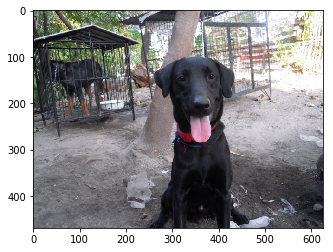

torch.Size([1, 3, 224, 224])
Hi dog,!
you look like a Flat-coated retriever

sample_dog_output.png


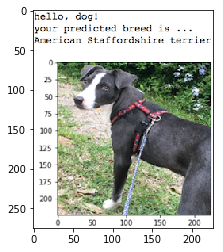

torch.Size([1, 3, 224, 224])
Hi dog,!
you look like a Great dane

Brittany_02625.jpg


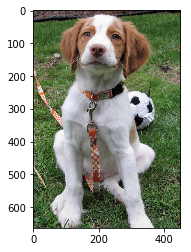

torch.Size([1, 3, 224, 224])
Hi dog,!
you look like a Brittany

sample_human_output.png


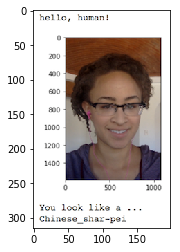

torch.Size([1, 3, 224, 224])
Human!
If you were a dog..You may look like a Brussels griffon

American_water_spaniel_00648.jpg


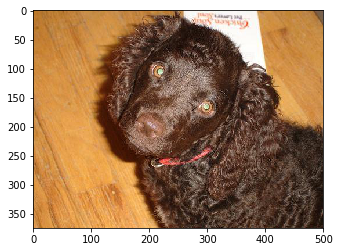

torch.Size([1, 3, 224, 224])
Hi dog,!
you look like a Curly-coated retriever

Curly-coated_retriever_03896.jpg


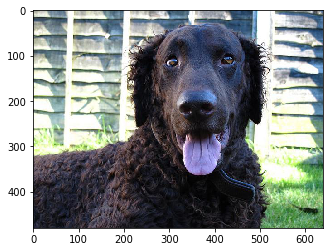

torch.Size([1, 3, 224, 224])
Hi dog,!
you look like a Curly-coated retriever

Labrador_retriever_06457.jpg


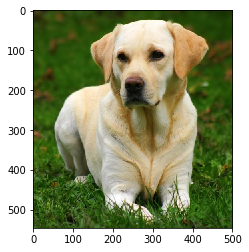

torch.Size([1, 3, 224, 224])
Hi dog,!
you look like a Labrador retriever

Labrador_retriever_06455.jpg


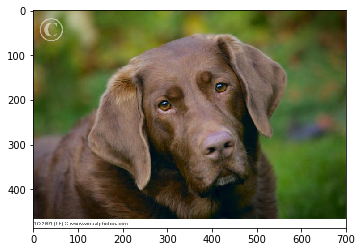

torch.Size([1, 3, 224, 224])
Hi dog,!
you look like a Chesapeake bay retriever

Welsh_springer_spaniel_08203.jpg


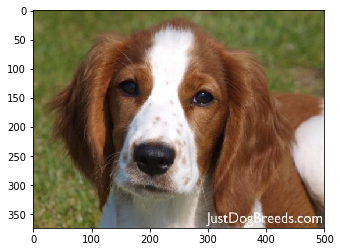

torch.Size([1, 3, 224, 224])
Hi dog,!
you look like a Welsh springer spaniel

sample_cnn.png


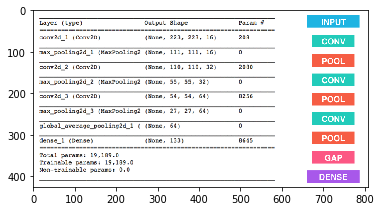

Error! nothing detected..



In [151]:
for img_file in os.listdir('./images'):
    img_path = os.path.join('./images/', img_file)
    print(img_file)
    run_app(img_path)

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

Much, Much better there are so many breeds that look alike!
I would improve the model maybe with:
- Resize the pics based on their size... I noticed that larges photos thends to have the dog away and small photos tends to have only the dogs face, so applying center resize for large photos may improve the model.
- I would add more final layers.
- For 25 epochs the validation error continued improving so I'm sure that increasing the epochs would improve the model.

__Answer:__ (Three possible points for improvement)

In [152]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, belowfot

5bf4b224-f4eb-4d7f-8048-67f57743322f.jpg


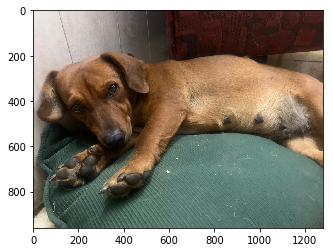

torch.Size([1, 3, 224, 224])
Hi dog,!
you look like a Dachshund

fd995bea-34d6-4ece-9e7b-c674052cee3e.jpg


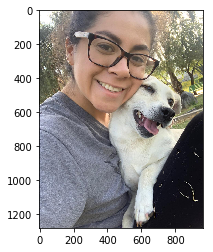

torch.Size([1, 3, 224, 224])
Hi dog,!
you look like a Great pyrenees

066d95bf-9bdd-4e65-b218-35cc320fd04b.jpg


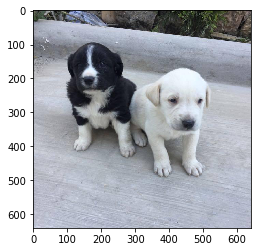

torch.Size([1, 3, 224, 224])
Hi dog,!
you look like a Border collie

d98c90e6-1de9-4d24-8a79-f295ec375ad9.jpg


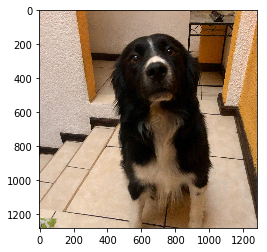

torch.Size([1, 3, 224, 224])
Hi dog,!
you look like a Border collie

Screen Shot 2020-01-27 at 23.19.01.png


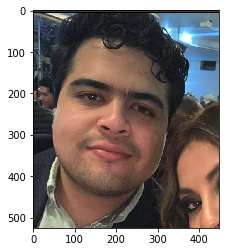

torch.Size([1, 3, 224, 224])
Human!
If you were a dog..You may look like a Bulldog

7cb68037-7ea1-4e06-8a87-e1468a59d18d.jpg


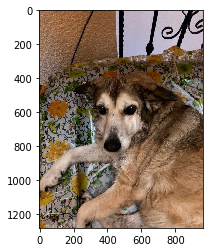

torch.Size([1, 3, 224, 224])
Hi dog,!
you look like a Alaskan malamute

061dc732-4184-4d9d-9208-58059574a770.jpg


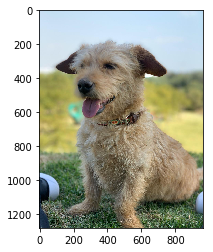

torch.Size([1, 3, 224, 224])
Hi dog,!
you look like a Norfolk terrier

c45eb019-5ca2-44f3-bf34-8468a554f482.jpg


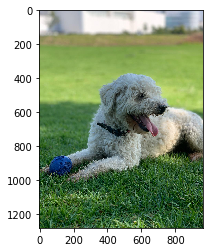

torch.Size([1, 3, 224, 224])
Hi dog,!
you look like a Bedlington terrier

a012a915-6de0-458e-9171-97f1ddb191af.jpg


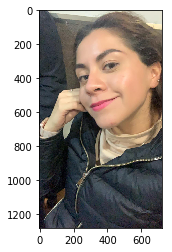

torch.Size([1, 3, 224, 224])
Human!
If you were a dog..You may look like a Havanese

14900365_350198735332982_7079839171223179976_n.jpg


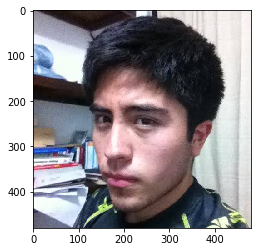

torch.Size([1, 3, 224, 224])
Human!
If you were a dog..You may look like a Poodle

.ipynb_checkpoints


IsADirectoryError: [Errno 21] Is a directory: './my_pics/.ipynb_checkpoints'

In [153]:
for img_file in os.listdir('./my_pics'):
    img_path = os.path.join('./my_pics/', img_file)
    print(img_file)
    run_app(img_path)

Sorry for the last error, I try to delete .ipynb_checkpoints but it appears just after I do it...

## Thank you for reviewing!!